In [1]:
from ABDB import database as db
import numpy as np
from rich.progress import track
import copy
import torch
from einops import rearrange
import json
import pandas as pd
from retrain_ablooper import *
import matplotlib.pyplot as plt
import math
import anarci

/Users/fabian/miniconda3/envs/auto-db-pipeline/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
Database path /Volumes/LaCie/sabdab-sabpred/data/ABDB was not found.


In [2]:
train = torch.load('train_data/train.pt')
validation = torch.load('train_data/val.pt')
test = torch.load('train_data/test.pt')

In [3]:
# functions to predict on val set and calculate RMSDs
def predict_on_val_set(val_dataloader, model):
    '''
    Predicts structures of validation set
    '''
    preds = []
    node_features = []
    geomouts = []

    with torch.no_grad():
        model.eval()
        for data in track(val_dataloader, description='Predict validation set'):
            coordinates, geomout, node_feature, mask = data['geomins'].float().to(device), data['geomouts'].float().to(device), data['encodings'].float().to(device), data['mask'].float().to(device)
            pred = model(node_feature, coordinates, mask)

            preds.append(pred)
            node_features.append(node_feature)
            geomouts.append(geomout)

    return preds, geomouts, node_features

def rmsds_on_val_set(preds, geomouts, node_features, decoys=5):
    '''
    Gets rmsds for each fab in the validation set and each decoy
    '''
    CDRs = ["H1", "H2", "H3", "L1", "L2", "L3"]
    cdr_rmsds = torch.zeros(100, decoys, 6)

    for i in range(len(preds)): # loop through the predictions
        for j in range(decoys):
            pred = preds[i][j,:,:,:]
            pred_in = rearrange(pred, "b i d -> () b i d")
            cdr_rmsd = rmsd_per_cdr(pred_in, node_features[i], geomouts[i], CDRs)
            cdr_rmsds[i,j,:] = cdr_rmsd

    return cdr_rmsds

In [4]:
# need to get atom_type, amino_type, coords
num2atom = {0: 'CA', 1: 'C', 2: 'N', 3: 'CB'}
num2loop = {0: 'H1', 1: 'H2', 2: 'H3', 3: 'L1', 4: 'L2', 5: 'L3', 6: 'Anchor'}
loop2num = {'H1': 0, 'H2': 1, 'H3': 2, 'L1': 3, 'L2': 4, 'L3': 5, 'Anchor': 6}

def reverse_one_hot(one_hot):
    '''
    Decodes a one hot encoded vector.
    '''
    for i in range(len(one_hot)):
        if one_hot[i] == 1:
            return i

    # happens when it gets to the padded part of the tensor
    return None

def get_atom_type(node_features):
    atom_encoding = node_features[-4:]
    a_num = reverse_one_hot(atom_encoding)
    if a_num == None:
        return None
    return num2atom[a_num]

def get_amino_type(node_features):
    amino_encoding = node_features[:20]
    aa_num = reverse_one_hot(amino_encoding)
    if aa_num == None:
        return None
    return short2long[num2short[aa_num]]

def get_loop(node_features):
    loop_encoding = node_features[30:37]
    l_num = reverse_one_hot(loop_encoding)
    if l_num == None:
        return None
    return num2loop[l_num]

# functions to produce pdb files for model outputs
def produce_pdb_text(coordinates, node_features, chain_name, CDRs):
    '''
    writes a pdb text for one predicted fab
    '''
    # coordinates 504 x 3
    # nodefeatures 504 x 41
    CDRs.append('Anchor')
    text = []
    j = 0
    for i in range(len(node_features)):
        atom_type = get_atom_type(node_features[i])
        amino_type = get_amino_type(node_features[i])
        loop = get_loop(node_features[i])

        if (atom_type == None and amino_type == None):
            continue

        if (atom_type == 'CB' and amino_type == 'GLY'):
            continue

        if loop not in CDRs:
            continue
        
        j += 1
        res_id = math.floor(i / 4)
        line = to_pdb_line(j, atom_type, amino_type, chain_name, res_id, coordinates[i])

        text.append(line)
    
    return text

def pdb_for_set(predictions, geomouts, node_features, out_dir, CDRs=['H1', 'H2', 'H3', 'L1', 'L2', 'L3', 'Anchor']):
    '''
    Produces pdb files for the predictions of the validation set. Decoys and ground truth are chains in a single file.
    '''
    n_anchors_before = loop2num[CDRs[0]] * 4 * 4
    n_anchors_after = (5 - loop2num[CDRs[-1]]) * 4 * 4
    
    for i in range(len(predictions)):

        prediction = predictions[i]
        geomout = geomouts[i]
        node_feature = node_features[i]

        

        pdb_text = []
        chains = ['D', 'P', 'Q', 'R', 'S', 'T']
        j = 0
        pdb_text += produce_pdb_text(geomout.squeeze(), node_feature.squeeze(), chains[j], CDRs)[n_anchors_before:-n_anchors_after]
        for decoy in prediction:
            j += 1
            pdb_text += produce_pdb_text(decoy.squeeze(), node_feature.squeeze(), chains[j], CDRs)[n_anchors_before:-n_anchors_after]

        
        pdb_text = ''.join(pdb_text) +'END'

        outfile = 'pdbs/'+out_dir+'/PRED'+str(i)+'.pdb'
        with open(outfile, 'w') as f:
            f.write(pdb_text)

### Notebook to check the input data and outputs of the ABlooper training

1. L1 prediction has a worse RMSD than ABlooper trained on Chotia
2. The training on 5 decoys leads to worse RMSDs than a single decoy

**1. Investigate L1**

Look at structures see if there is something thats going wrong

In [20]:
# torch settings
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float)

model = MaskDecoyGen(decoys=1).to(device = device).float()
model.load_state_dict(torch.load("best_models/best_model-2104-RAdam-1",
                                 map_location=torch.device(device)))

batch_size = 1

val_dataloader = torch.utils.data.DataLoader(validation, 
                                             batch_size=batch_size,
                                             num_workers=1,
                                             shuffle=True,
                                             pin_memory=True,
                                             )

In [21]:
# takes 2 min
predictions, geomouts, node_features = predict_on_val_set(val_dataloader, model)

Predict validation set ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺  98% 0:00:05

In [26]:
cdr_rmsd = rmsds_on_val_set(predictions, geomouts, node_features, decoys=1)

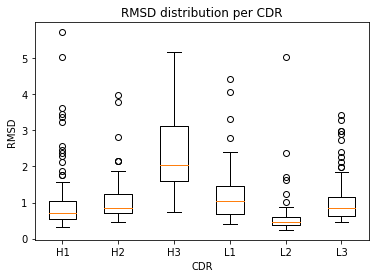

In [27]:
plt.boxplot([x for x in rearrange(cdr_rmsd.mean(1), 'a b -> b a')],labels=['H1', 'H2', 'H3', 'L1', 'L2', 'L3']);
plt.title('RMSD distribution per CDR')
plt.ylabel('RMSD')
plt.xlabel('CDR')
plt.savefig('figures/RMSD_distribution_per_cdr_2104-RAdam-1.png');

In [28]:
# produce pdbs
pdb_for_set(predictions, geomouts, node_features, out_dir='2104_Radam_1', CDRs=['L1'])

In [25]:
# sorted by L1 rmds
sorted = np.argsort(np.array(cdr_rmsd[:,0,3].tolist()))
top5 = sorted[-5:]
bottom5 = sorted[:5]
top5, bottom5

(array([ 8, 12, 32, 73, 18]), array([72, 64, 83, 70, 24]))

**2. Investigate 5 decoys**

2.1 Check distributions of CDR lengths in the training and validation sets

In [9]:
def length_CDRs(data_set, CDRs=["H1", "H2", "H3", "L1", "L2", "L3"]):
    '''
    Returns the length of all 6 CDRs for all fabs in a data set
    '''
    CDR_lengths = dict()

    node_features_set = torch.zeros(len(data_set), 504, 41)

    for i in range(len(data_set)):
        _, _, node_features, _ = data_set[i]['geomins'], data_set[i]['geomouts'], data_set[i]['encodings'], data_set[i]['mask']

        node_features_set[i,:,:] = node_features

    for CDR in CDRs:
        resis = loop_resi_index(node_features_set, CDR)
        
        lengths = []
        for resi in resis: # loop throught each fab
            length = len(resi)/4
            if length % 1 != 0: # This should not happen each residue has 4 atoms
                raise Exception('Number of atoms not multiple of 4')
            lengths.append(length)
        
        CDR_lengths[CDR] = lengths

    return CDR_lengths

In [10]:
# takes 2 min
CDR_lengths_train = length_CDRs(train)
CDR_lengths_val = length_CDRs(validation)

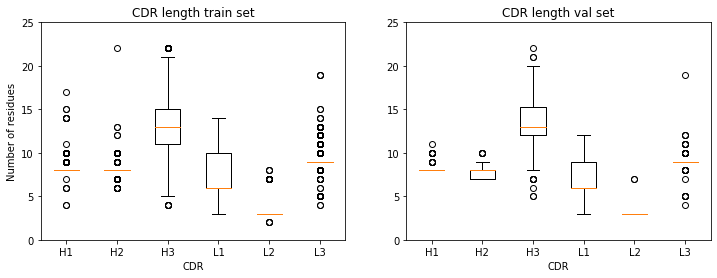

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].boxplot([x for x in CDR_lengths_train.values()],labels=[x for x in CDR_lengths_train.keys()]) 
axs[1].boxplot([x for x in CDR_lengths_val.values()],labels=[x for x in CDR_lengths_val.keys()])

axs[0].set_title('CDR length train set')
axs[1].set_title('CDR length val set')
axs[0].set_ylabel('Number of residues')
axs[0].set_xlabel('CDR')
axs[1].set_xlabel('CDR')
axs[0].set_ylim([0,25])
axs[1].set_ylim([0,25])
fig.savefig('figures/CDR_length_train_val_sets.png');

Lengths of CDRs in train and validation sets look very similar

**2.2 RMSD distribution across the decoys**

All predictions base on 2504-Radam-5-1

In [7]:
# torch settings
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float)

model = MaskDecoyGen(decoys=5).to(device = device).float()
model.load_state_dict(torch.load("best_models/best_model-2504-Radam-5-1",
                                 map_location=torch.device(device)))

batch_size = 1

val_dataloader = torch.utils.data.DataLoader(validation, 
                                             batch_size=batch_size,
                                             num_workers=1,
                                             shuffle=True,
                                             pin_memory=True,
                                             )

<All keys matched successfully>

In [7]:
predictions, geomouts, node_features = predict_on_val_set(val_dataloader, model)

Predict validation set ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━  85% 0:06:19

In [12]:
#predictions_on_val = {'preds': predictions, 'geomouts': geomouts, 'node_features': node_features}
#torch.save(predictions_on_val, 'train_data/predictions_on_val.pt')

predictions_on_val = torch.load('train_data/predictions_on_val.pt')

predictions = predictions_on_val['preds']
geomouts = predictions_on_val['geomouts']
node_features = predictions_on_val['node_features']

In [13]:
cdr_rmsd = rmsds_on_val_set(predictions, geomouts, node_features)

Text(0.5, 0, 'CDR')

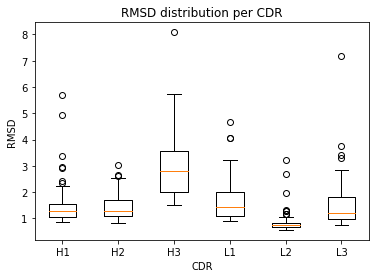

In [17]:
plt.boxplot([x for x in rearrange(cdr_rmsd.mean(1), 'a b -> b a')],labels=['H1', 'H2', 'H3', 'L1', 'L2', 'L3']);
plt.title('RMSD distribution per CDR')
plt.ylabel('RMSD')
plt.xlabel('CDR')

Distribution of RMSDs for each CDR across all 5 decoys

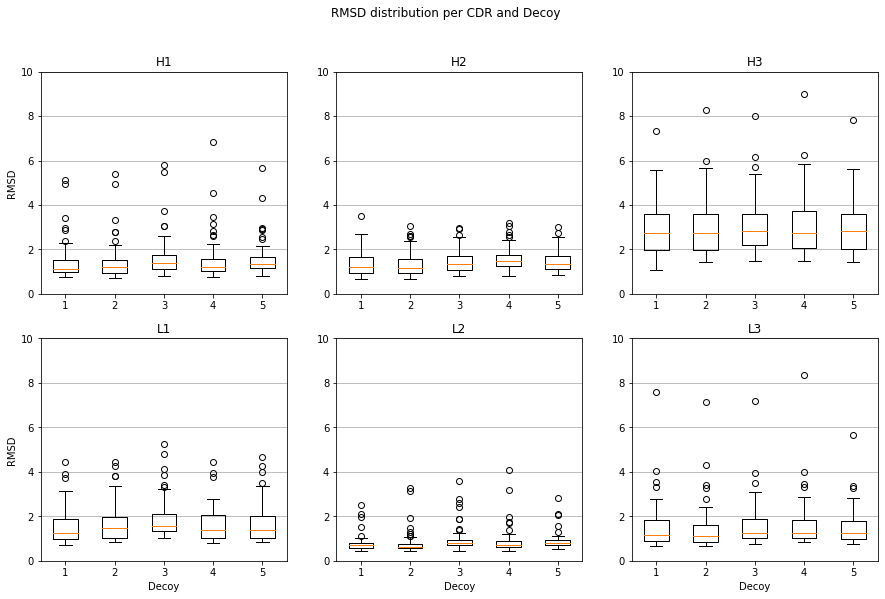

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(15,9))

CDRs = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']

k = 0
for i in range(2):
    for j in range(3):
        axs[i,j].boxplot([x for x in rearrange(cdr_rmsd[:,:,k], 'a b -> b a')],labels=['1', '2', '3', '4', '5']);
        axs[i,j].set_title(CDRs[k])
        axs[i,0].set_ylabel('RMSD')
        axs[1,j].set_xlabel('Decoy')
        axs[i,j].set_ylim([0,10])
        axs[i,j].grid(axis='y')
        k+=1
fig.suptitle('RMSD distribution per CDR and Decoy')
fig.savefig('figures/RMSD_distribution_per_CDR_Decoy.png');

There is no decoy thats significantly worse than the others and by itself causing the high RMSD

**2.3 Look at structures predicted with 5 Decoys**

Write the predictions in a .pdb file so it can be looked at with pymol

In [81]:
pdb_for_set(predictions, geomouts, node_features, out_dir='2504_Radam_5_1')

In [15]:
sorted = np.argsort(np.array(cdr_rmsd.tolist()).mean(1)[:,2])
top5 = sorted[-5:]
bottom5 = sorted[:5]
top5, bottom5

(array([21, 94, 36, 16,  9]), array([61, 38, 81, 19,  1]))

**2.4 check if numbering is correct**

Compare numbering from sabdab with the same sequences relabelled with anarci

In [2]:
# functions to compare sabdab and anarci numberings

def get_regions_sabdab(fab):

    sabdab_numbering = {'cdrh1':[], 'cdrh2':[], 'cdrh3':[], 'cdrl1':[], 'cdrl2':[], 'cdrl3':[]}

    for chain in [fab.VH, fab.VL]:
        for residue in fab.get_structure()[chain].get_residues():
            if residue.region in sabdab_numbering.keys():
                sabdab_numbering[residue.region].append(long2short[residue.resname])

    return sabdab_numbering

def get_regions_anarci(fab):

    anarci_numbering = {'cdrh1':[], 'cdrh2':[], 'cdrh3':[], 'cdrl1':[], 'cdrl2':[], 'cdrl3':[]}

    cdr_boundaries = {'1':[27,38], '2':[56,65], '3':[105,117]}
    
    for seq in fab.get_sequence().split('/'):
        result = anarci.run_anarci([['sequences', seq]])
        numbered_seq = result[1][0][0][0]
        chain = result[2][0][0]['chain_type']
        chain = chain.replace('K', 'L')

        for residue in numbered_seq:
            for cdr in cdr_boundaries.keys():
                if cdr_boundaries[cdr][0] <= residue[0][0] and residue[0][0] <= cdr_boundaries[cdr][1]:
                    if residue[1] != '-':
                        anarci_numbering['cdr'+chain.lower()+cdr].append(residue[1])

    return anarci_numbering



def compare_fab_sabdab_to_anarci(fab):

    ana = get_regions_anarci(fab)
    sab = get_regions_sabdab(fab)

    wrong_numbered_cdrs = []
    for CDR in ana:
        if ana[CDR] != sab[CDR]:
            wrong_numbered_cdrs.append(CDR)

    return wrong_numbered_cdrs


def compare_sabdab_to_anarci(pdb_list):

    db.set_numbering_scheme("imgt")
    db.set_region_definition("imgt")    

    wrong_numbered = list()
    correct = list()
    excep = list()

    for pdb_id in track(pdb_list, description='Compared SAbDab and Anarci numbering'):

        pdb = db.fetch(pdb_id)

        for i in range(len(pdb.fabs)):
            try: # in case there are some numbering problems with anarci skip the fab
                wrong_numbered_cdrs = compare_fab_sabdab_to_anarci(pdb.fabs[i])
                if wrong_numbered_cdrs:
                    wrong_numbered.append([pdb_id, i, wrong_numbered_cdrs])
                else:
                    correct.append([pdb_id, i])
            except Exception as e:
                excep.append([pdb_id, i, e])

    return wrong_numbered, correct, excep
            

In [3]:
all_pdbs_in_sabdab = list(db.db_summary.keys())
len(all_pdbs_in_sabdab)

5770

In [4]:
filtered = filter_abs(all_pdbs_in_sabdab)
len(filtered)

Filter PDBs for resolution ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

Number of PDBs with missing chains or identical chain names: 1298



Number of PDBs with resolution worse than 3.0: 1408



3064

In [6]:
w, c, e = compare_sabdab_to_anarci(filtered)

Compared SAbDab and Anarci numbering ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

total: 5022 fabs with wrong numbering: 961


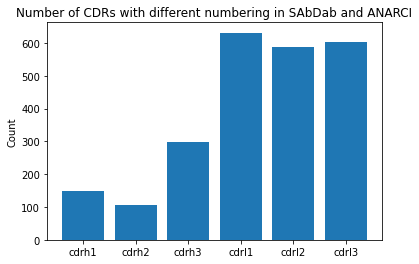

In [8]:
total = len(c) + len(w)
print('total:', total, 'fabs with wrong numbering:', len(w))

conc = np.hstack(np.array(w,  dtype='object')[:,2])
unique, counts = np.unique(conc, return_counts=True)

plt.bar(unique, counts)
plt.ylabel('Count')
plt.title('Number of CDRs with different numbering in SAbDab and ANARCI')
plt.savefig('figures/difference_CDR_numbering_sabdab_anarci.png');

Around 20% of the fabs have different numbering in anarci and sabdab